In [49]:
# FinanceData를 받아오기 위한 다운로드
# pip install finance-datareader

In [50]:
# GUI
import tkinter as tk
import tkinter.ttk as ttk
import tkinter.messagebox as msgbox
from tkinter import *  # __all__
from tkinter import filedialog

# Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

# Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback

# ETC
import os
import warnings

In [51]:
'''global Value(Hyper parameter)'''
STOCK_CODE = 0
WINDOW_SIZE = 20
BATCH_SIZE = 32  # 원래는 32
Epoch_num = 100
earlystop = 20
while_TF_early_stop = True

In [52]:
## 주가 데이터 가져오기(GOOGLE_A_Class)
STOCK_CODE = "GOOGL"
stock = fdr.DataReader(STOCK_CODE)

In [53]:
# 가져온 Data의 모습
stock.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2004-08-20,2.71,2.54,2.73,2.51,228590000.0,0.0797
2004-08-23,2.74,2.77,2.84,2.73,182800000.0,0.0111
2004-08-24,2.62,2.78,2.79,2.59,152640000.0,-0.0438
2004-08-25,2.65,2.63,2.70,2.60,91980000.0,0.0115
2004-08-26,2.70,2.63,2.70,2.62,71020000.0,0.0189


In [54]:
stock.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-07-12,114.02,116.22,116.97,113.69,29960000.0,-0.0143
2022-07-13,111.35,111.70,114.20,111.20,43720000.0,-0.0234
2022-07-14,110.37,110.21,111.09,108.37,37000000.0,-0.0088
2022-07-15,111.78,112.00,113.14,110.90,46770000.0,0.0128
2022-07-18,109.03,112.64,113.68,108.37,43160000.0,-0.0246


In [55]:
# Code 시작
warnings.filterwarnings('ignore')

# 데이터 전처리 시작
scaler = MinMaxScaler() #SKLearn을 이용하여 정규화를 시작한다.

# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)
scaled

array([[8.31070973e-05, 2.49283310e-04, 4.15535487e-05, 2.90810392e-04,
        2.75841507e-01],
       [4.01684304e-04, 4.01623111e-04, 3.46279572e-04, 3.32354733e-04,
        2.20118286e-01],
       [4.15535487e-04, 3.32377747e-04, 1.52363012e-04, 1.66177367e-04,
        1.83415679e-01],
       ...,
       [1.49218793e-01, 1.50317836e-01, 1.46670176e-01, 1.49379604e-01,
        4.26899019e-02],
       [1.51698155e-01, 1.53156896e-01, 1.50174525e-01, 1.51332189e-01,
        5.45793073e-02],
       [1.52584631e-01, 1.53904746e-01, 1.46670176e-01, 1.47523957e-01,
        5.01861903e-02]])

In [56]:
#train / test data 분할
x_train, x_test, y_train, y_test = train_test_split(
    df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3607, 4), (3607,), (902, 4), (902,))

In [57]:
#TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)


In [58]:

# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [59]:
# 모델
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=48, kernel_size=5,
            padding="causal",
            activation="relu",
            input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [60]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer,
                metrics=['mse'])

In [61]:
# earlystopping은 earlystop에서 설정된 횟수만큼 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=earlystop)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename,
                                save_weights_only=True,
                                save_best_only=True,
                                monitor='val_loss',
                                verbose=1)

In [62]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=Epoch_num, 
                    callbacks=[checkpoint, earlystopping])


Epoch 1/50
    111/Unknown - 3s 8ms/step - loss: 1.3918e-04 - mse: 2.7835e-04
Epoch 1: val_loss improved from inf to 0.00027, saving model to tmp\ckeckpointer.ckpt
113/113 [==============================] - 4s 15ms/step - loss: 1.3785e-04 - mse: 2.7570e-04 - val_loss: 2.7102e-04 - val_mse: 5.4205e-04
Epoch 2/50
110/113 [============================>.] - ETA: 0s - loss: 1.3509e-04 - mse: 2.7019e-04
Epoch 2: val_loss improved from 0.00027 to 0.00019, saving model to tmp\ckeckpointer.ckpt
113/113 [==============================] - 1s 11ms/step - loss: 1.3265e-04 - mse: 2.6531e-04 - val_loss: 1.9247e-04 - val_mse: 3.8493e-04
Epoch 3/50
113/113 [==============================] - ETA: 0s - loss: 1.2955e-04 - mse: 2.5910e-04
Epoch 3: val_loss did not improve from 0.00019
113/113 [==============================] - 1s 12ms/step - loss: 1.2955e-04 - mse: 2.5910e-04 - val_loss: 2.7117e-04 - val_mse: 5.4234e-04
Epoch 4/50
111/113 [============================>.] - ETA: 0s - loss: 1.3595e-04 - mse:

In [63]:
model.load_weights(filename)
pred = model.predict(test_data)

28/28 [==============================] - 1s 4ms/step


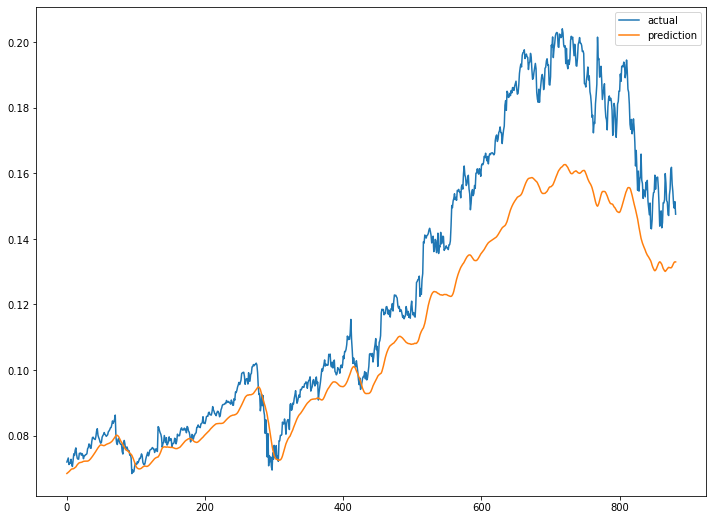

In [64]:
# 결과에 대한 그래프 출력(예측 데이터 시각화)
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [65]:
# 최근의 예상값을 출력합니다.
maxim = stock.max()
minim = stock.min()
range = maxim['Close']-minim['Close']
result = pred * range + minim['Close']
pred_price = result[-1][0]
print("예상금액 : {}" .format(pred_price))

예상금액 : 98.52310943603516
